In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [18]:
import sys
sys.path.insert(0, './libraries')
from DataGenerator import DataGenerator
import tensorflow as tf
from Speckle2Void import Speckle2V

from IPython.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

%reload_ext autoreload
%autoreload 2


In [28]:
import rasterio
import numpy as np
from rasterio.plot import reshape_as_image
with rasterio.open('/media/jp/FreeAgent GoFlex Drive/SAR/SLC_raw/AE04/VH.tif') as src:
    img = src.read()
    img = reshape_as_image(img)
new_array = np.expand_dims(img[:,:,:1], axis=0)

## Instantiate the model

In [20]:
tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()
batch_size=16

dir_train = "../DataSet_SAR/TerraSAR_X/HDF5_SLC_DECORRELATED_2/"
dir_test = "../DataSet_SAR/TerraSAR_X/HDF5_SLC_TEST_DECORRELATED_2/"

file_checkpoint = 's2v_checkpoint/model.ckpt-299999'#None for the latest checkpoint

model = Speckle2V(dir_train,
                  dir_test,
                  file_checkpoint,
                  batch_size=batch_size,
                  patch_size=64,
                  model_name='speckle2void',
                  lr=1e-04, 
                  steps_per_epoch=2000,
                  k_penalty_tv=5e-05,
                  shift_list=[3,1],
                  prob = [0.9,0.1],
                  clip=500000,
                  norm=100000,
                  L_noise=1)    

## Build the inference computational graph and load the network

In [21]:
model.build_inference()
model.load_weights()

/home/jp/Documents/IME/TCC/CODE/my_project_v2/Speckle2Void.py:231: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  x1 = tf.compat.v1.layers.batch_normalization(x1, axis=-1,training=self.is_train,name='bn_{0}'.format(i+1))
/home/jp/Documents/IME/TCC/CODE/my_project_v2/Speckle2Void.py:263: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  x1 = tf.compat.v1.layers.batch_normalization(x1, axis=-1,training=self.is_train,name='bn_{0}'.format(i+1))


Taking the specified checkpoint...
INFO:tensorflow:Restoring parameters from s2v_checkpoint/model.ckpt-299999


## Speckle2Void Prediction

In [29]:
cleaned_img= model.predict(new_array)

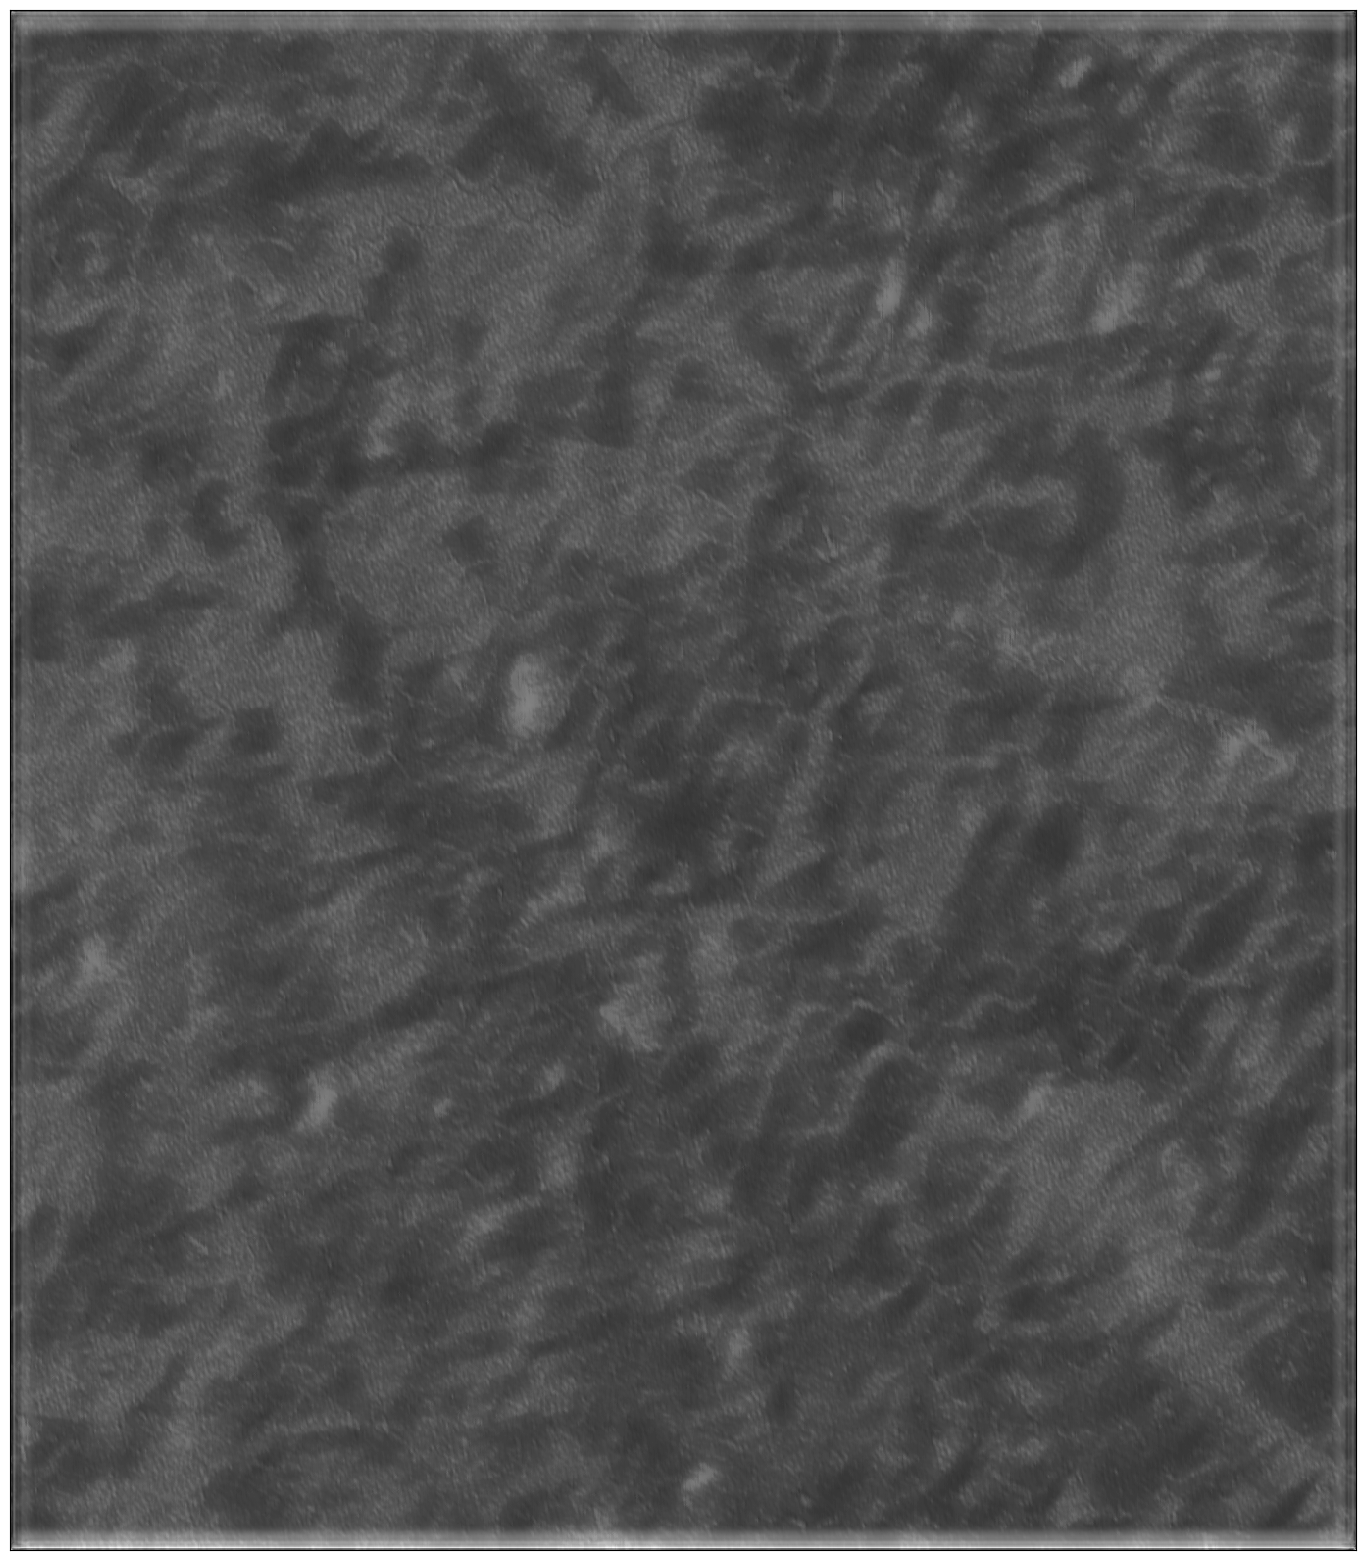

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=[20,20])
plt.imshow(cleaned_img[0,:,:,0] ,cmap = 'gray', interpolation = 'none')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

## Save image to png

In [31]:
plt.imsave('area2_VH_despeckle.png',cleaned_img[0,:,:,0] , cmap='gray')

In [13]:
type(cleaned_img)

numpy.ndarray

/home/jp/.local/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


grayscale shape: (843, 1230, 3)


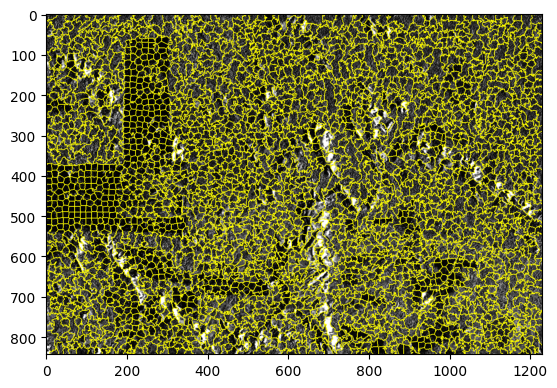

In [9]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import skimage.segmentation as seg
grayscale_src = rasterio.open('/home/jp/Documents/IME/TCC/NEW/saved_segmentations/area1_despeckle.png')
grayscale = rescale_img(grayscale_src, 843, 1230)
grayscale = grayscale[:3, :, :]
grayscale = grayscale.transpose(1, 2, 0)
plt.imshow(grayscale)
print(f'grayscale shape: {grayscale.shape}')
grayscale_slic = seg.slic(grayscale, n_segments=5000)
grayscale_with_bounds = seg.mark_boundaries(image=grayscale, label_img=grayscale_slic)
plt.imshow(grayscale_with_bounds)
# plt.imsave('/home/jp/Documents/IME/TCC/NEW/saved_segmentations/despeckle_slic.png', grayscale_with_bounds)
np.save('/home/jp/Documents/IME/TCC/NEW/saved_segmentations/despeckle_rescale.npy', grayscale_slic)

In [2]:
def rescale_img(src, w, h):
    data = src.read(
        out_shape=(
            src.count,
            w,
            h
        ),
        )

# scale image transform
    transform = src.transform * src.transform.scale(
        (src.width / data.shape[-1]),
        (src.height / data.shape[-2])
    )

    return data

/home/jp/.local/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


grayscale shape: (998, 977, 3)


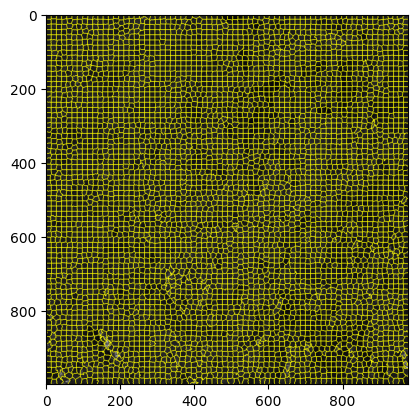

In [11]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import skimage.segmentation as seg
grayscale_src = rasterio.open('/home/jp/Documents/IME/TCC/CODE/my_project_v2/area3_despeckle.png')
grayscale = rescale_img(grayscale_src, 998, 977)
grayscale = grayscale[:3, :, :]
grayscale = grayscale.transpose(1, 2, 0)
plt.imshow(grayscale)
print(f'grayscale shape: {grayscale.shape}')
grayscale_slic = seg.slic(grayscale, n_segments=5000)
grayscale_with_bounds = seg.mark_boundaries(image=grayscale, label_img=grayscale_slic)
plt.imshow(grayscale_with_bounds)
# plt.imsave('/home/jp/Documents/IME/TCC/NEW/saved_segmentations/despeckle_slic.png', grayscale_with_bounds)
np.save('/home/jp/Documents/IME/TCC/NEW/saved_segmentations/area3_despeckle_rescale.npy', grayscale_slic)

(1785, 1560)

In [14]:
grayscale.shape

(1572, 1374, 3)

grayscale shape: (998, 977, 3)


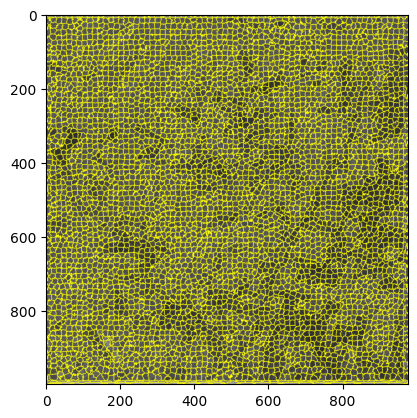

In [78]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import skimage.segmentation as seg
grayscale_src = rasterio.open('/home/jp/Documents/IME/TCC/CODE/my_project_v2/area3_RGB_despeckle.png')
grayscale = rescale_img(grayscale_src, 998, 977)
# grayscale = grayscale_src.read()
grayscale = grayscale[:3, :, :]
grayscale = grayscale.transpose(1, 2, 0)
plt.imshow(grayscale)
print(f'grayscale shape: {grayscale.shape}')
grayscale_slic = seg.slic(grayscale, n_segments=5000)
grayscale_with_bounds = seg.mark_boundaries(image=grayscale, label_img=grayscale_slic)
plt.imshow(grayscale_with_bounds)
plt.imsave('/home/jp/Documents/IME/TCC/NEW/saved_segmentations/area3_RGB_despeckle_slic_resize.png', grayscale_with_bounds)
np.save('/home/jp/Documents/IME/TCC/NEW/saved_segmentations/area3_RGB_despeckle_resize.npy', grayscale_slic)

grayscale shape: (2026, 1984, 3)


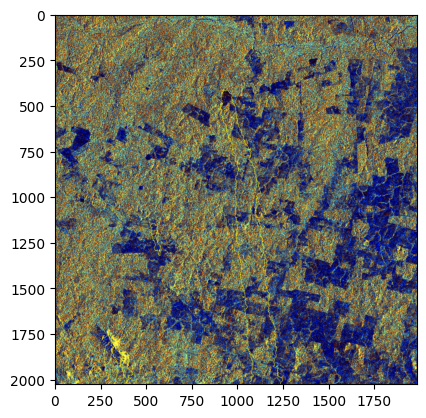

In [79]:
grayscale_src = rasterio.open('/home/jp/Documents/IME/TCC/CODE/my_project_v2/test_examples/RGB_AREA_X03_S1.tif')
# grayscale = rescale_img(grayscale_src, 998, 977)
grayscale = grayscale_src.read()
grayscale = grayscale[:3, :, :]
grayscale = grayscale.transpose(1, 2, 0)
plt.imshow(grayscale)
print(f'grayscale shape: {grayscale.shape}')
grayscale_slic = seg.slic(grayscale, n_segments=5000)
grayscale_with_bounds = seg.mark_boundaries(image=grayscale, label_img=grayscale_slic)
plt.imshow(grayscale_with_bounds)
plt.imsave('/home/jp/Documents/IME/TCC/NEW/saved_segmentations/area3_RGB_RAW_slic.png', grayscale_with_bounds)
np.save('/home/jp/Documents/IME/TCC/NEW/saved_segmentations/area3_RGB_RAW.npy', grayscale_slic)

In [22]:
t = np.load('/home/jp/Documents/IME/TCC/CODE/Capstone-Project/data/truth/ae2_s1.npy')
t.shape

(1979, 2877)

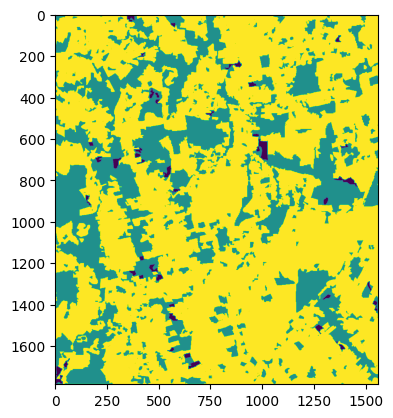

In [20]:
plt.imshow(t)

grayscale shape: (1979, 2877, 3)
(1979, 2877)


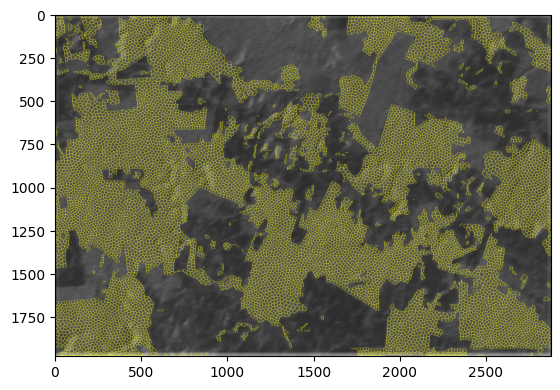

In [23]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import skimage.segmentation as seg

def get_maskslic_mask(full_mask):
    new_array = np.full((full_mask.shape[0], full_mask.shape[1]), 0)

    # Conditions for assigning values based on channels
    # If channel 1 value is 255, assign 1; if channel 2 value is 1, assign 2; else, keep as 3
    new_array[full_mask[:, :] == 1] = 1
    new_array[full_mask[:, :] == 2] = 1
    return new_array

grayscale_src = rasterio.open('/home/jp/Documents/IME/TCC/CODE/my_project_v2/area2_VV_despeckle.png')
grayscale = rescale_img(grayscale_src, 1979, 2877)
# grayscale = grayscale_src.read()
grayscale = grayscale[:3, :, :]
grayscale = grayscale.transpose(1, 2, 0)
plt.imshow(grayscale)
mask = t
print(f'grayscale shape: {grayscale.shape}')
print(mask.shape)
grayscale_slic = seg.slic(grayscale, n_segments=10000, mask=get_maskslic_mask(mask))
grayscale_with_bounds = seg.mark_boundaries(image=grayscale, label_img=grayscale_slic)
plt.imshow(grayscale_with_bounds)
plt.imsave('/home/jp/Documents/IME/TCC/NEW/saved_segmentations/area2_despeckle_maskslic.png', grayscale_with_bounds)
np.save('/home/jp/Documents/IME/TCC/NEW/saved_segmentations/area2_despeckle_maskslic.npy', grayscale_slic)

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import skimage.segmentation as seg
grayscale_src = rasterio.open('/home/jp/Documents/IME/TCC/NEW/saved_segmentations/area1_despeckle.png')
grayscale = rescale_img(grayscale_src, 843, 1230)
grayscale = grayscale[:3, :, :]
grayscale = grayscale.transpose(1, 2, 0)
plt.imshow(grayscale)
print(f'grayscale shape: {grayscale.shape}')
grayscale_slic = seg.slic(grayscale, n_segments=5000)
grayscale_with_bounds = seg.mark_boundaries(image=grayscale, label_img=grayscale_slic)
plt.imshow(grayscale_with_bounds)
# plt.imsave('/home/jp/Documents/IME/TCC/NEW/saved_segmentations/despeckle_slic.png', grayscale_with_bounds)
np.save('/home/jp/Documents/IME/TCC/NEW/saved_segmentations/despeckle_rescale.npy', grayscale_slic)

grayscale shape: (2132, 2093, 3)
(2132, 2093)


/home/jp/.local/lib/python3.8/site-packages/scipy/cluster/vq.py:602: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


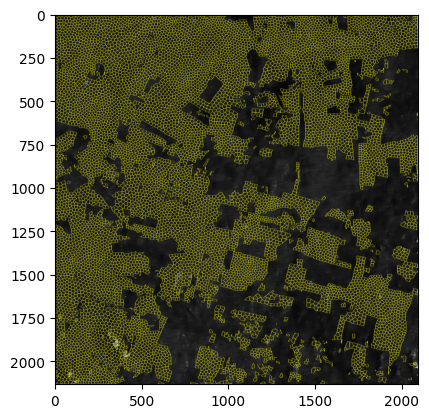

In [3]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import skimage.segmentation as seg
grayscale_src = rasterio.open('/home/jp/Documents/IME/TCC/CODE/my_project_v2/area3_despeckle.png')
grayscale = rescale_img(grayscale_src, 2132, 2093)
# grayscale = grayscale_src.read()
grayscale = grayscale[:3, :, :]
grayscale = grayscale.transpose(1, 2, 0)
plt.imshow(grayscale)
mask = np.load('/home/jp/Pictures/new_truth/ae03_MASCARA_CERTA_REAL_OFICIAL.npy')
print(f'grayscale shape: {grayscale.shape}')
print(mask.shape)
grayscale_slic = seg.slic(grayscale, n_segments=10000, mask=mask)
grayscale_with_bounds = seg.mark_boundaries(image=grayscale, label_img=grayscale_slic)
plt.imshow(grayscale_with_bounds)
plt.imsave('/home/jp/Documents/IME/TCC/NEW/saved_segmentations/area3__despeckle_maskslic_10000.png', grayscale_with_bounds)
np.save('/home/jp/Documents/IME/TCC/NEW/saved_segmentations/area3_despeckle_maskslic_10000.npy', grayscale_slic)

/home/jp/.local/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


(2990, 2933)
grayscale shape: (2048, 2048, 3)


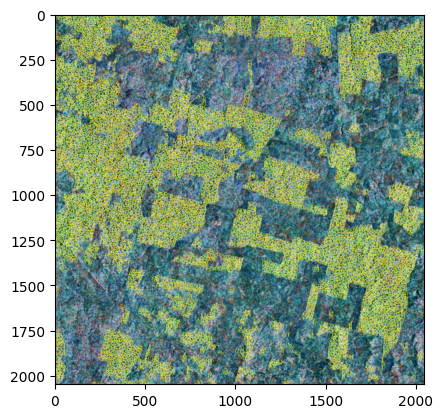

In [11]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import skimage.segmentation as seg
from scipy import ndimage

grayscale_src = rasterio.open('/home/jp/Documents/IME/TCC/NEW/AREA3_COL_BANDA2.PNG')
# grayscale = rescale_img(grayscale_src, 2132, 2093)
grayscale = grayscale_src.read()
grayscale = grayscale[:3, :, :]
grayscale = grayscale.transpose(1, 2, 0)
plt.imshow(grayscale)
mask = np.load('/home/jp/Pictures/new_truth/ae03_MASCARA_CERTA_REAL_OFICIAL.npy')
target_shape = (2990, 2933)

# Resize the array using SciPy's resize function
mask = ndimage.zoom(mask, 
                            (target_shape[0] / mask.shape[0], target_shape[1] / mask.shape[1]), 
                            order=3) 
print(mask.shape)
mask = mask[mask.shape[0]-2048:mask.shape[0],mask.shape[1]-2048:mask.shape[1]]
print(f'grayscale shape: {grayscale.shape}')

grayscale_slic = seg.slic(grayscale, n_segments=10000, mask=mask)
grayscale_with_bounds = seg.mark_boundaries(image=grayscale, label_img=grayscale_slic)
plt.imshow(grayscale_with_bounds)
plt.imsave('/home/jp/Documents/IME/TCC/NEW/saved_segmentations/area3_colorized_maskslic_10000.png', grayscale_with_bounds)
np.save('/home/jp/Documents/IME/TCC/NEW/saved_segmentations/area3_colorized_maskslic_10000.npy', grayscale_slic)

In [8]:
path = '/home/jp/Downloads/AREA3_GRD_corrected.tif'
grayscale_src = rasterio.open(path)
# grayscale = rescale_img(grayscale_src, 2132, 2093)
grayscale = grayscale_src.read()
grayscale = grayscale[:3, :, :]
grayscale = grayscale.transpose(1, 2, 0)
grayscale.shape

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(2990, 2933, 2)

In [9]:
mask = np.load('/home/jp/Pictures/new_truth/ae03_MASCARA_CERTA_REAL_OFICIAL.npy')
mask.shape

(2132, 2093)

In [10]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import skimage.segmentation as seg
from scipy import ndimage

grayscale_src = rasterio.open('/home/jp/Documents/IME/TCC/NEW/AREA3_COL_BANDA2.PNG')
# grayscale = rescale_img(grayscale_src, 2132, 2093)
grayscale = grayscale_src.read()
grayscale = grayscale[:3, :, :]
grayscale = grayscale.transpose(1, 2, 0)
plt.imshow(grayscale)
mask = np.load('/home/jp/Pictures/new_truth/ae03_MASCARA_CERTA_REAL_OFICIAL.npy')
target_shape = (2990, 2933)

# Resize the array using SciPy's resize function
mask = ndimage.zoom(mask, 
                            (target_shape[0] / mask.shape[0], target_shape[1] / mask.shape[1]), 
                            order=3) 
print(mask.shape)
mask = mask[mask.shape[0]-2048:mask.shape[0],mask.shape[1]-2048:mask.shape[1]]
print(f'grayscale shape: {grayscale.shape}')

grayscale_slic = seg.slic(grayscale, n_segments=10000, mask=mask)
grayscale_with_bounds = seg.mark_boundaries(image=grayscale, label_img=grayscale_slic)
plt.imshow(grayscale_with_bounds)
plt.imsave('/home/jp/Documents/IME/TCC/NEW/saved_segmentations/area3_colorized_maskslic_10000.png', grayscale_with_bounds)
np.save('/home/jp/Documents/IME/TCC/NEW/saved_segmentations/area3_colorized_maskslic_10000.npy', grayscale_slic)

numpy.ndarray

In [24]:
path = '/media/jp/FreeAgent GoFlex Drive/SAR/SLC_raw/AE02/VH.tif'
grayscale_src = rasterio.open(path)
# grayscale = rescale_img(grayscale_src, 2132, 2093)
grayscale = grayscale_src.read()
grayscale = grayscale[:3, :, :]
grayscale = grayscale.transpose(1, 2, 0)
grayscale.shape

(1899, 2734, 3)

In [25]:
t = np.load('/home/jp/Documents/IME/TCC/CODE/Capstone-Project/data/truth/ae2_s1.npy')
t.shape

(1979, 2877)

In [26]:
t = np.load('/home/jp/Documents/IME/TCC/CODE/Capstone-Project/data/truth/ae2_s2.npy')
t.shape

(2798, 4026)

In [ ]:
grayscale_src = rasterio.open('/home/jp/Pictures/AREA2_VH.PNG')
# grayscale = rescale_img(grayscale_src, 2132, 2093)
grayscale = grayscale_src.read()
grayscale = grayscale[:3, :, :]
grayscale = grayscale.transpose(1, 2, 0)
plt.imshow(grayscale)
mask = t
target_shape = (1899, 2734)

# Resize the array using SciPy's resize function
mask = ndimage.zoom(mask, 
                            (target_shape[0] / mask.shape[0], target_shape[1] / mask.shape[1]), 
                            order=3) 
print(mask.shape)
mask = mask[mask.shape[0]-2048:mask.shape[0],mask.shape[1]-2048:mask.shape[1]]
print(f'grayscale shape: {grayscale.shape}')

first_slic = seg.slic(grayscale, n_segments=10000)
np.save('/home/jp/Documents/IME/TCC/NEW/saved_segmentations/area2_colorized.npy')

grayscale_slic = seg.slic(grayscale, n_segments=10000, mask=get_maskslic_mask(mask))
grayscale_with_bounds = seg.mark_boundaries(image=grayscale, label_img=grayscale_slic)
plt.imshow(grayscale_with_bounds)
plt.imsave('/home/jp/Documents/IME/TCC/NEW/saved_segmentations/area2_colorized_maskslic.png', grayscale_with_bounds)
np.save('/home/jp/Documents/IME/TCC/NEW/saved_segmentations/area2_colorized_maskslic.npy', grayscale_slic)